In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/train.csv
/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/test.csv
/kaggle/input/nlp-dataset/train.csv
/kaggle/input/nlp-dataset/test.csv


In this notebook, I am going to classify Turkish film comments shared in beyazperde.com with the help of [BERTurk pretrained language model](https://github.com/stefan-it/turkish-bert) using PyTorch and Huggingface Transformers library.

*In order to speed up the training process, I recommend to use GPU provided by Kaggle.*

Set device type as CUDA to utilize GPU:

In [20]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: Tesla P100-PCIE-16GB


# 1) Exploratory Data Analysis

In [8]:
df_train=pd.read_csv("/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/train.csv",index_col=[0],encoding="windows-1252")
df_test=pd.read_csv("/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/test.csv",index_col=[0],encoding="windows-1252")

In [21]:
nlp_train=pd.read_csv("/kaggle/input/nlp-dataset/train.csv", index_col=[0])
nlp_test=pd.read_csv("/kaggle/input/nlp-dataset/test.csv",index_col=[0],encoding="windows-1252")

In [10]:
df_train["comment"][0]

'biri bana bu filmde benim anlamadigim bisey oldugunu söylesin lütfen.. uzun zamandir bilim kurgu vb tür filmleri izliyorum basit olanlari,mantiksiz olanlari,hatali olanlari gördüm ama böylesine rastlamadim saçma filmler kategorisinde kesin bi ödül alir film.kisaca:bu ne ya? diyorsunuz.. . \n'

In [4]:
from unidecode import unidecode

def convert_to_ascii(text):
    return unidecode(text)

In [12]:
# applying the conversion function to all dataframe
nlp_train["Label"] = nlp_train["Sentence"]
nlp_train["Sentence"] = nlp_train["Sentence"].apply(convert_to_ascii)

In [10]:
nlp_train.head()

,Sentence,Label
ID,,
0,"sinif , havuz ve acik deniz calismalariyla , t...","sınıf , havuz ve açık deniz çalışmalarıyla , t..."
1,"bu standart , sualtinda kendini rahat hisseden...","bu standart , sualtında kendini rahat hisseden..."
2,"yapilan arastirmalar , ogrencilerin mevcut dal...","yapılan araştırmalar , öğrencilerin mevcut dal..."
3,"pdic ogrencilerinde , psikolojik egitim ve yet...","pdıc öğrencilerinde , psikolojik eğitim ve yet..."
4,"pdic egitiminin sagladigi guven ve rahatlik , ...","pdıc eğitiminin sağladığı güven ve rahatlık , ..."


In [11]:
df_train["Sentence"].value_counts()

KeyError: 'Sentence'

In [ ]:
nlp_train.isna().sum()

* The dataset is highly balanced. 
* There is no missing value.

## Unigram and Bigram Distributions in Each Class

To understand the dataset, let's have a look at the common top-15 unigrams and bigrams' frequencies for each class. To generate them, we need to tokenize each comments by using **nltk** library.

### **POSITIVE CLASS UNIGRAMS**

In [18]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
stop_words=stopwords.words("turkish")

stop_words.extend(["bir","film","filmi","filme","filmde","filmden","filmin","kadar","bi","ben"]) #sone extra corpus-related stopwords
print(stopwords)

exclude = set(string.punctuation)

#for positive sentiments
df_pos=df_train[df_train["Label"]==1]

#for only unigrams
token_list=[]
for i,r in df_pos.iterrows():
    text=''.join(ch for ch in df_pos["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies
    token_list.extend(tokens)
    
frequencies=Counter(token_list)

frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)

top_15=dict(frequencies_sorted[0:15])

<WordListCorpusReader in '/usr/share/nltk_data/corpora/stopwords'>


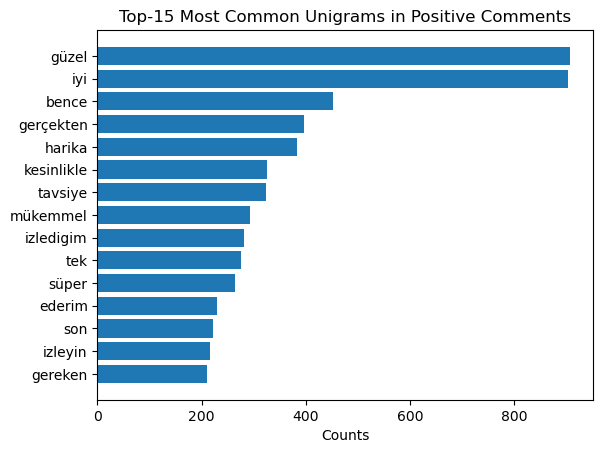

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Unigrams in Positive Comments')

plt.show()

### **NEGATIVE CLASS UNIGRAMS**

In [20]:
#for negative sentiments
df_neg=df_train[df_train["Label"]==0]

#for only unigrams
token_list=[]

for i,r in df_neg.iterrows():
    text=''.join(ch for ch in df_neg["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies
    token_list.extend(tokens)
    
frequencies=Counter(token_list)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

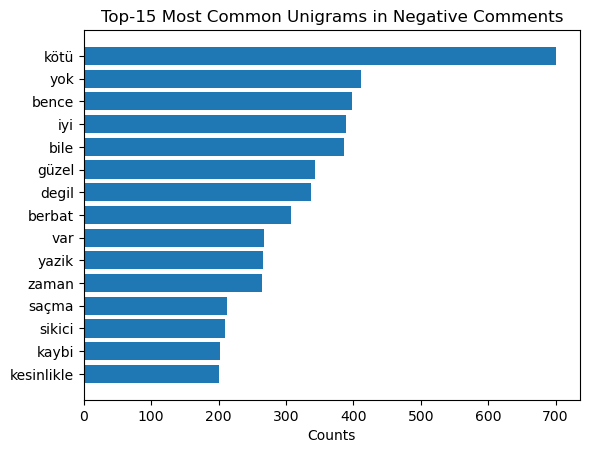

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Unigrams in Negative Comments')

plt.show()

Even the majority of common words are quite sensible, when only unigrams are explored, some words does not make sense. For example, "güzel" in Turkish has positive meaning (the most common unigram in the positive comments). However, it is one of the most common (5th one) single word in the negative comments. Therefore, the word before and after "güzel" gains more importance. Let's have a look at the bigrams :) 

### **POSITIVE CLASS BIGRAMS**

In [23]:
from nltk.util import ngrams

token_list=[]

for i,r in df_pos.iterrows():
    text=''.join(ch for ch in df_pos["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies 
    token_list.extend(tokens)
    
 
bigrams=list(ngrams(token_list,2))
frequencies=Counter(bigrams)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])


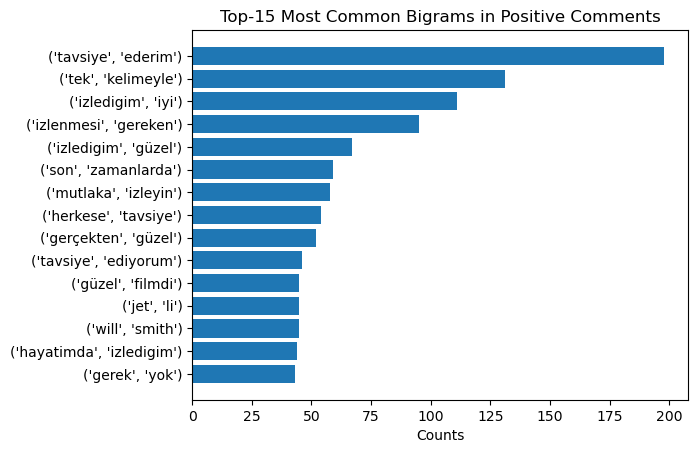

In [24]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Bigrams in Positive Comments')

plt.show()

In [25]:
token_list=[]

for i,r in df_neg.iterrows():
    text=''.join(ch for ch in df_neg["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies 
    token_list.extend(tokens)
    
 
bigrams=list(ngrams(token_list,2))
frequencies=Counter(bigrams)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

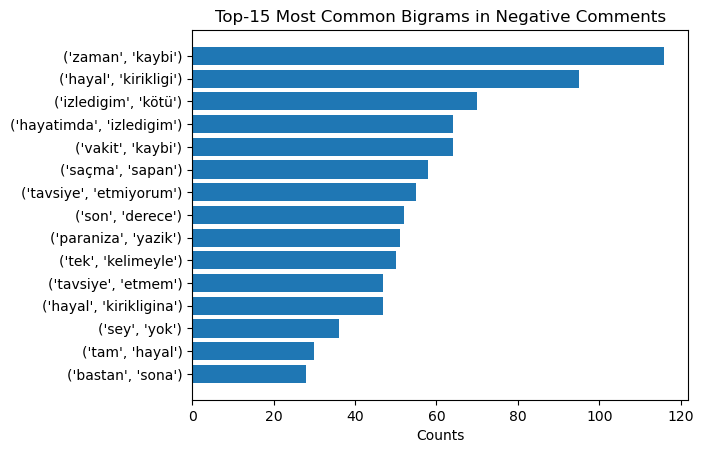

In [26]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Bigrams in Negative Comments')

plt.show()

With bigram distributions in each class, the dataset seems to have quite good labels. Let's dive into classification model!

# 2) BERTURK Model Fine Tuning

In [13]:
# Get the comments and their labels from training data as series.
comments = df_train.comment.values
labels = df_train.Label.values

In [14]:
sentences = nlp_train.Sentence.values
labels = nlp_train.Label.values

In [22]:
# Create sentence and label lists for test data
sentences1 = nlp_test.Sentence.values


As stated in https://stackoverflow.com/questions/54938815/data-preprocessing-for-nlp-pre-training-models-e-g-elmo-bert, BERT has word piece tokenizer and it magicly helps with dirty data. Therefore, there is no so much need to apply preprocessing steps.


In [23]:
from transformers import AutoTokenizer
#Load BERT Turkish tokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased",do_lower_case=True)

Since BERT takes maximum 512 tokens as input, we need to take care of input lengths. To show length of embeddings in the data will be helpful to determine maximum length of comments and padding threshold.

In [16]:

import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    print(max(tokenized_texts_len))
    ax.hist(tokenized_texts_len);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

6810


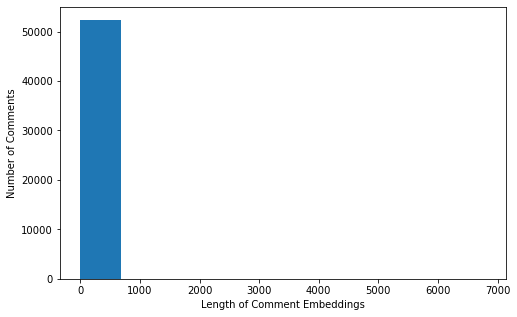

In [17]:
plot_sentence_embeddings_length(sentences,tokenizer)

In [18]:
sentences

array(['sinif , havuz ve acik deniz calismalariyla , tum dunyada gecerli , basarili bir standart olusturmustur . ',
       'bu standart , sualtinda kendini rahat hisseden herkesin , sportif dalici olabilecegini , bunun icin fiziki guc ve cok iyi yuzme bilmenin sart olmadigini savunur . ',
       'yapilan arastirmalar , ogrencilerin mevcut dalis kurslarini tamamladiktan sonra bile , kendilerini denizde ( dogal sualti sartlarinda ) ve acil durumlarda rahat hissetmediklerini gostermistir . ',
       ..., ' yanlis bir proje doga dahi bu projeye karsi cikacaktir ',
       ' butun canlilar bu projeye karsi diye konustu ',
       ' son guncelleme 12:33 '], dtype=object)

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def segment_text(sentence, label, max_length=512, overlap=50):
    tokens = tokenizer.tokenize(sentence)
    new = []
    if len(tokens) <= max_length:
        return sentence, label
    else: 
        return None, None


In [27]:
def data_segments(sentences, labels, max_length=128):
    all_text = []
    all_labels = []

    for sentence, label in zip(sentences, labels):
        segment_s, segment_l = segment_text(sentence, label, max_length=max_length, overlap=50)
        if segment_s:
            all_text.append(segment_s)
            all_labels.append(segment_l)
            
    return all_text, all_labels

#new_sentences, new_labels = data_segments(sentences, labels)

In [28]:
test_sentences, test_labels = data_segments(sentences1, sentences1)

In [22]:
np.array(new_sentences)

array(['sinif , havuz ve acik deniz calismalariyla , tum dunyada gecerli , basarili bir standart olusturmustur . ',
       'bu standart , sualtinda kendini rahat hisseden herkesin , sportif dalici olabilecegini , bunun icin fiziki guc ve cok iyi yuzme bilmenin sart olmadigini savunur . ',
       'yapilan arastirmalar , ogrencilerin mevcut dalis kurslarini tamamladiktan sonra bile , kendilerini denizde ( dogal sualti sartlarinda ) ve acil durumlarda rahat hissetmediklerini gostermistir . ',
       ..., ' yanlis bir proje doga dahi bu projeye karsi cikacaktir ',
       ' butun canlilar bu projeye karsi diye konustu ',
       ' son guncelleme 12:33 '], dtype='<U577')

In [23]:
np.array(new_labels)

array(['sınıf , havuz ve açık deniz çalışmalarıyla , tüm dünyada geçerli , başarılı bir standart oluşturmuştur . ',
       'bu standart , sualtında kendini rahat hisseden herkesin , sportif dalıcı olabileceğini , bunun için fiziki güç ve cok iyi yüzme bilmenin şart olmadığını savunur . ',
       'yapılan araştırmalar , öğrencilerin mevcut dalış kurslarını tamamladıktan sonra bile , kendilerini denizde ( doğal sualtı şartlarında ) ve acil durumlarda rahat hissetmediklerini göstermiştir . ',
       ..., ' yanlış bir proje doğa dahi bu projeye karşı çıkacaktır ',
       ' bütün canlılar bu projeye karşı diye konuştu ',
       ' son güncelleme 12:33 '], dtype='<U577')

It seems almost all comments have less than 100 tokens, therefore instead of 512, we can set maximum length as 128.

indices=tokenizer.batch_encode_plus(comments,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_id=indices["input_ids"]
attention_masks_s=indices["attention_mask"]
print(input_ids[0])
print(comments[0])
print(attention_masks[0])

In [20]:
indices=tokenizer.batch_encode_plus(new_sentences,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]
print(input_ids[0])
print(new_sentences[0])
print(attention_masks[0])

[2, 16751, 1066, 16, 8725, 1992, 29252, 4456, 22063, 5484, 18740, 16, 13526, 1027, 26905, 24419, 3575, 1028, 2031, 16, 21070, 2194, 1996, 5538, 14330, 2033, 2002, 9474, 2293, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sinif , havuz ve acik deniz calismalariyla , tum dunyada gecerli , basarili bir standart olusturmustur . 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [21]:
indices=tokenizer.batch_encode_plus(new_labels,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
output_ids=indices["input_ids"]
print(output_ids[0])
print(new_labels[0])

[2, 3825, 16, 8725, 1992, 2416, 4456, 24513, 16, 2525, 5292, 5953, 16, 4165, 1996, 5538, 27202, 2293, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sınıf , havuz ve açık deniz çalışmalarıyla , tüm dünyada geçerli , başarılı bir standart oluşturmuştur . 


In [27]:
len(input_ids[0])

128

In [22]:
from sklearn.model_selection import train_test_split

# Use 99% for training and 1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, output_ids, 
                                                            random_state=42, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, output_ids,
                                             random_state=42, test_size=0.2)

In [23]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, pin_memory=True)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size, pin_memory=True)

In [ ]:
vocab_size = len(tokenizer.vocab)
print("Vocabulary size:", vocab_size)

In [32]:
from transformers import BertModel, BertConfig
import torch
from torch import nn

class BertSeq2Seq(nn.Module):
    def __init__(self, bert_model_name, vocab_size):
        super(BertSeq2Seq, self).__init__()
        self.bert_encoder = BertModel.from_pretrained(bert_model_name)
        self.decoder = nn.GRU(input_size=768, hidden_size=768, num_layers=1, batch_first=True)
        self.out = nn.Linear(768, vocab_size)

    def forward(self, input_ids, decoder_input_ids):
        encoder_outputs = self.bert_encoder(input_ids)[0]
        decoder_outputs, _ = self.decoder(encoder_outputs)
        logits = self.out(decoder_outputs)
        return logits

# Example usage
model = BertSeq2Seq("dbmdz/bert-base-turkish-cased", vocab_size=32000)
model.cuda()

"""
input_ids = torch.tensor([[101, 2057, 2293, 2070, 102]])  # example token ids for "[CLS] We love some [SEP]"
decoder_input_ids = torch.tensor([[0]*5])  # Dummy decoder input ids, typically start tokens or previous outputs
logits = model(input_ids, decoder_input_ids)
"""

'\ninput_ids = torch.tensor([[101, 2057, 2293, 2070, 102]])  # example token ids for "[CLS] We love some [SEP]"\ndecoder_input_ids = torch.tensor([[0]*5])  # Dummy decoder input ids, typically start tokens or previous outputs\nlogits = model(input_ids, decoder_input_ids)\n'

In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
config = AutoConfig.from_pretrained(
        "dbmdz/bert-base-turkish-cased",num_labels=2)
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased",config=config)

model.cuda()

In [9]:
from transformers import BertModel, AutoConfig
import torch
from torch import nn

class BertSeq2Seq(nn.Module):
    def __init__(self, model_name, config):
        super(BertSeq2Seq, self).__init__()
        self.config = config
        self.bert_encoder = BertModel.from_pretrained(model_name, config=config)
        self.decoder = nn.GRU(input_size=config.hidden_size, 
                              hidden_size=config.hidden_size, 
                              num_layers=1, 
                              batch_first=True)
        self.out = nn.Linear(config.hidden_size, config.vocab_size)

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get outputs from the encoder
        encoder_outputs = self.bert_encoder(input_ids, attention_mask=attention_mask)
        
        # Check if the encoder outputs are in a tuple and get the last hidden state
        if isinstance(encoder_outputs, tuple):  # Older versions might return a tuple
            encoder_last_hidden_state = encoder_outputs[0]
        else:  # Newer versions return a model-specific output object
            encoder_last_hidden_state = encoder_outputs.last_hidden_state

        # Pass the last hidden state to the decoder
        decoder_outputs, _ = self.decoder(encoder_last_hidden_state)
        logits = self.out(decoder_outputs)

        outputs = (logits,)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.vocab_size), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # returns (loss, logits) if labels provided


# Load configuration from pre-trained model
config = AutoConfig.from_pretrained("dbmdz/bert-base-turkish-cased")
config.vocab_size = 32000  # You might need to set the vocab size if it's crucial for your model
#config.hidden_size = 256  # Reduce hidden size
config.num_attention_heads = 8  # Reduce the number of attention heads

# Initialize your model with the loaded configuration
model = BertSeq2Seq("dbmdz/bert-base-turkish-cased", config)


In [ ]:
print(config.hidden_size,
config.num_attention_heads
)

In [10]:
model.cuda()

BertSeq2Seq(
  (bert_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [25]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  betas=[0.9,0.999],
                  eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [11]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [12]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
"""
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 30 batches.
        if step % 30 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
"""

In [34]:
import time
import numpy as np
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

# Assuming your model and dataloaders have already been defined and initialized
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Function to measure time elapsed
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

for epoch_i in range(epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    total_loss = 0
    model.train()
    t0 = time.time()  # Start time for the epoch

    for step, batch in enumerate(train_dataloader):
        if step % 30 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step:>5,} of {len(train_dataloader):>5,}. Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0] if isinstance(outputs, tuple) else outputs.loss

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"  Average training loss: {avg_train_loss:.2f}")

    # Validation
    print("Running Validation...")
    model.eval()
    eval_loss, eval_accuracy, nb_eval_steps = 0, 0, 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            logits = outputs[1] if isinstance(outputs, tuple) else outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Example of how you might calculate accuracy for seq2seq. Adjust as necessary.
        tmp_eval_accuracy = np.mean(np.argmax(logits, axis=-1) == label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print(f"  Validation Accuracy: {eval_accuracy / nb_eval_steps:.2f}")


======== Epoch 1 / 2 ========
Training...
  Batch    30 of 2,606. Elapsed: 0:00:08.
  Batch    60 of 2,606. Elapsed: 0:00:17.
  Batch    90 of 2,606. Elapsed: 0:00:25.
  Batch   120 of 2,606. Elapsed: 0:00:33.
  Batch   150 of 2,606. Elapsed: 0:00:41.
  Batch   180 of 2,606. Elapsed: 0:00:50.
  Batch   210 of 2,606. Elapsed: 0:00:58.
  Batch   240 of 2,606. Elapsed: 0:01:06.
  Batch   270 of 2,606. Elapsed: 0:01:14.
  Batch   300 of 2,606. Elapsed: 0:01:23.
  Batch   330 of 2,606. Elapsed: 0:01:31.
  Batch   360 of 2,606. Elapsed: 0:01:39.
  Batch   390 of 2,606. Elapsed: 0:01:47.
  Batch   420 of 2,606. Elapsed: 0:01:55.
  Batch   450 of 2,606. Elapsed: 0:02:04.
  Batch   480 of 2,606. Elapsed: 0:02:12.
  Batch   510 of 2,606. Elapsed: 0:02:20.
  Batch   540 of 2,606. Elapsed: 0:02:28.
  Batch   570 of 2,606. Elapsed: 0:02:37.
  Batch   600 of 2,606. Elapsed: 0:02:45.
  Batch   630 of 2,606. Elapsed: 0:02:53.
  Batch   660 of 2,606. Elapsed: 0:03:01.
  Batch   690 of 2,606. Elapsed: 0

In [2]:
import torch
# Save the model's state dictionary
torch.save(model.state_dict(), '/kaggle/working/bert_seq2seq_state_dict.pth')

# Optionally, save the tokenizer and configuration if you're using a Hugging Face tokenizer
tokenizer.save_pretrained('/kaggle/working')


NameError: name 'model' is not defined

In [13]:
from transformers import BertModel, AutoConfig
# Load configuration from pre-trained model
config = AutoConfig.from_pretrained("dbmdz/bert-base-turkish-cased")
config.vocab_size = 32000  # You might need to set the vocab size if it's crucial for your model
#config.hidden_size = 256  # Reduce hidden size
config.num_attention_heads = 8  # Reduce the number of attention heads

model = BertSeq2Seq(model_name="dbmdz/bert-base-turkish-cased", config=config)
model.load_state_dict(torch.load('/kaggle/working/bert_seq2seq_state_dict.pth'))

<All keys matched successfully>

# 3) BERTurk Model Performance on Test Set 

In [30]:
# Create sentence and label lists for test data

indices1=tokenizer.batch_encode_plus(test_sentences,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

"""
l_indices1=tokenizer.batch_encode_plus(test_labels,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
output_ids1=l_indices1["input_ids"]
"""

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)
#prediction_labels1 = torch.tensor(output_ids1)

# Set the batch size.  
batch_size = 8 
"""
# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size, pin_memory=True)
"""
# Create a dataset from the encoded inputs
test_dataset = TensorDataset(prediction_inputs1, prediction_masks1)

# Create a DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=8,pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

predictions = []

for batch in test_dataloader:
    # Move batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        # Forward pass
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs[0]

    # Move logits to CPU and convert to numpy arrays
    logits = logits.detach().cpu().numpy()
    predictions.extend(logits)

# Optionally, convert logits to actual tokens or texts
predicted_token_ids = np.argmax(predictions, axis=-1)
predicted_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in predicted_token_ids]
predicted_texts = [tokenizer.convert_tokens_to_string(tokens) for tokens in predicted_tokens]


In [18]:
test_sentences

NameError: name 'test_sentences' is not defined

In [33]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
sentence = "Sample undiacritized sentence here."
input_ids = tokenizer.encode(sentence, return_tensors="pt")


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Send input to the appropriate device
input_ids = input_ids.to(device)

# Initialize the decoder's first input (typically the encoder's last hidden state)
with torch.no_grad():
    encoder_outputs = model.bert_encoder(input_ids)
    decoder_input = encoder_outputs.last_hidden_state  # Assuming this is what you feed into the decoder

    # Sequence generation loop here (you need to add this logic based on your task)
    # For simplicity, let's assume you are doing one step of decoding
    # This part needs actual implementation based on your decoder's specifics
    logits = model.out(decoder_input)
    predicted_token_ids = torch.argmax(logits, dim=-1)

# Decode token IDs to text
predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_token_ids.squeeze().tolist())
predicted_text = tokenizer.convert_tokens_to_string(predicted_tokens)
print(predicted_text)


AttributeError: 'tuple' object has no attribute 'last_hidden_state'

In [32]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

# Single sentence for testing
sentence = "Your example sentence here."
inputs = tokenizer.batch_encode_plus([sentence],max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)

# Move to device
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

input_ids= torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)
# Inference
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs[0]  # Adjust based on your model output format

# Output processing
probabilities = torch.softmax(logits, dim=-1)
predicted_class_id = probabilities.argmax().item()

print(f"Predicted class ID: {predicted_class_id}")


RuntimeError: Expected object of device type cuda but got device type cpu for argument #3 'index' in call to _th_index_select

In [57]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1, b_labels1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  label_ids1 = b_labels1.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits1)
  true_labels.append(label_ids1)

print('    DONE.')

Predicting labels for 2,666 test sentences...
    DONE.


In [58]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [59]:
from sklearn.metrics import accuracy_score
print("Accuracy of BERT is:",accuracy_score(flat_true_labels, flat_predictions))

Accuracy of BERT is: 0.9339834958739685


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

### **We reach 93% accuracy score on this highly balanced dataset even without hyperparameter optimization with BERTURK base model. For comparison, ULMFit pretrained language model based on LSTMs which is develoed by fastai team, has [91% accuracy score](https://github.com/fastai/course-nlp/blob/master/nn-turkish.ipynb) in this dataset. Also, Gezici (2018), *Sentiment Analysis in Turkish* has 75%.**

### If you like this network, feel free to UPVOTE :) 